In [238]:
import pandas as pd
import seaborn as sns
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [239]:
data = pd.read_csv('data/laptops.csv').drop(['Unnamed: 0', 'img_link'], axis=1)
data.shape

(984, 10)

### missing values

In [240]:
data.isna().sum()*100/data.shape[0]

name                 0.000000
price(in Rs.)        0.000000
processor            0.000000
ram                  0.000000
os                   0.000000
storage              0.000000
display(in inch)     0.000000
rating              30.081301
no_of_ratings       30.081301
no_of_reviews       30.081301
dtype: float64

In [241]:
data[~data['rating'].isna()].isna().sum()

name                0
price(in Rs.)       0
processor           0
ram                 0
os                  0
storage             0
display(in inch)    0
rating              0
no_of_ratings       0
no_of_reviews       0
dtype: int64

- The same records have missing values for rating, no_of_ratings and no_of_reviews columns
- I am going to impute the missing values with negative one. Meaning if there is a missing rating then the rating is -1 and the number of ratings will be -1 and also the number of reviews will be negative one

In [242]:
data.fillna(-1, inplace=True)

### duplicates

In [243]:
data.duplicated().sum()

212

- We have 212 records duplicated. These records will not add any value to out analysis. I will therefore drop them

In [244]:
data.drop_duplicates(keep='first', inplace=True)

In [245]:
data.shape

(772, 10)

In [246]:
def to_lower(text: str)->str:
    return str(text).lower()

text_columns = ['name', 'processor', 'ram', 'storage', 'os']
for col in text_columns:
    data[col] = data[col].apply(to_lower)

### column names

In [247]:
data.rename(columns={'price(in Rs.)': 'price_in_rs', 'display(in inch)': 'display_in_inch'}, inplace=True)

In [248]:
data.head()

,name,price_in_rs,processor,ram,os,storage,display_in_inch,rating,no_of_ratings,no_of_reviews
0,lenovo intel core i5 11th gen,62990,intel core i5 processor (11th gen),16 gb ddr4 ram,windows 11 operating system,512 gb ssd,15.6,4.5,14.0,1.0
1,lenovo v15 g2 core i3 11th gen,37500,intel core i3 processor (11th gen),8 gb ddr4 ram,64 bit windows 11 operating system,1 tb hdd|256 gb ssd,15.6,4.4,53.0,3.0
2,asus tuf gaming f15 core i5 10th gen,49990,intel core i5 processor (10th gen),8 gb ddr4 ram,windows 11 operating system,512 gb ssd,15.6,4.4,4733.0,463.0
3,asus vivobook 15 (2022) core i3 10th gen,33990,intel core i3 processor (10th gen),8 gb ddr4 ram,64 bit windows 11 operating system,512 gb ssd,15.6,4.3,10406.0,1040.0
4,lenovo athlon dual core,18990,amd athlon dual core processor,4 gb ddr4 ram,dos operating system,256 gb ssd,14.0,3.8,18.0,3.0


## name

- checking if name column has repeatitions

In [249]:
len(data['name'].unique()) == data.shape[0]

False

In [250]:
data[['name', 'price_in_rs']]\
    .groupby('name')\
    .count()\
    .sort_values(by='price_in_rs')\
    .shape

(498, 1)

In [251]:
data[data['name']=='dell core i5 12th gen']

,name,price_in_rs,processor,ram,os,storage,display_in_inch,rating,no_of_ratings,no_of_reviews
48,dell core i5 12th gen,67990,intel core i5 processor (12th gen),16 gb ddr4 ram,64 bit windows 11 operating system,512 gb ssd,15.6,4.5,28.0,0.0
61,dell core i5 12th gen,57990,intel core i5 processor (12th gen),8 gb ddr4 ram,windows 11 operating system,1 tb hdd|256 gb ssd,15.6,3.8,25.0,2.0
164,dell core i5 12th gen,57990,intel core i5 processor (12th gen),8 gb ddr4 ram,64 bit windows 11 operating system,512 gb ssd,15.6,3.9,30.0,2.0
193,dell core i5 12th gen,78190,intel core i5 processor (12th gen),16 gb ddr5 ram,64 bit windows 11 operating system,512 gb ssd,13.3,4.5,8.0,0.0
225,dell core i5 12th gen,76519,intel core i5 processor (12th gen),8 gb ddr4 ram,64 bit windows 11 operating system,512 gb ssd,14.0,4.5,4.0,1.0
250,dell core i5 12th gen,63890,intel core i5 processor (12th gen),8 gb ddr4 ram,64 bit windows 11 operating system,512 gb ssd,15.6,-1.0,-1.0,-1.0
365,dell core i5 12th gen,88990,intel core i5 processor (12th gen),8 gb ddr5 ram,64 bit windows 11 operating system,512 gb ssd,14.0,-1.0,-1.0,-1.0
588,dell core i5 12th gen,60090,intel core i5 processor (12th gen),8 gb ddr4 ram,windows 11 operating system,512 gb ssd,15.6,-1.0,-1.0,-1.0
612,dell core i5 12th gen,94075,intel core i5 processor (12th gen),8 gb ddr4 ram,windows 11 operating system,1 tb hdd|256 gb ssd,15.6,-1.0,-1.0,-1.0
734,dell core i5 12th gen,99990,intel core i5 processor (12th gen),16 gb ddr5 ram,windows 11 operating system,512 gb ssd,13.4,-1.0,-1.0,-1.0


The name column cannot be used as an id column because it contains repeatitions

In [252]:
data['laptop'] = data['name'].str.split(expand=True)[0]

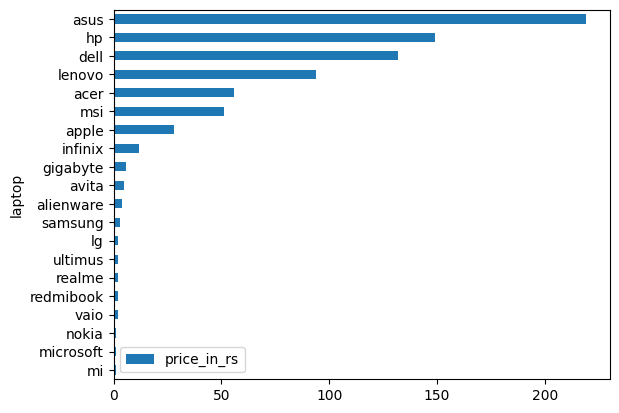

In [253]:
data[['laptop', 'price_in_rs']]\
    .groupby('laptop')\
    .count()\
    .sort_values(by='price_in_rs')\
    .plot(kind='barh');

In [254]:
del data['name']

### processor

In [255]:
[i for i in list(data['processor'].unique()) if 'intel' not in i]

['amd athlon dual core processor',
 'apple m1 processor',
 'amd ryzen 3 quad core processor',
 'amd ryzen 3 dual core processor',
 'amd ryzen 5 hexa core processor',
 'amd ryzen 7 octa core processor',
 'qualcomm snapdragon 7c gen 2 processor',
 'amd ryzen 5 quad core processor',
 'apple m2 processor',
 'amd dual core processor',
 'amd ryzen 9 octa core processor',
 'apple m1 max processor',
 'apple m1 pro processor',
 'apple m2 pro processor',
 'amd ryzen 9 octa core processor (5th gen)',
 'amd ryzen 9 octa core processor (9th gen)',
 'amd ryzen 5 dual core processor (5th gen)',
 'amd ryzen 7 quad core processor',
 'amd ryzen 7 hexa core processor',
 'amd ryzen 5 hexa core processor (10th gen)',
 'amd ryzen 5 dual core processor (10th gen)',
 'amd ryzen 7 octa core processor (5th gen)',
 'amd ryzen 9 octa core processor (10th gen)',
 'amd apu dual core a6 processor',
 'amd ryzen 3 dual core processor (3rd gen)',
 'amd ryzen 7 octa core processor (4th gen)',
 'mediatek mediatek kompani

In [256]:
def extract_processor(processor: str)->list:
    processor_split = processor.split()
    processor_manufacturer = processor_split[0]
    if 'intel' in processor:
        if any([i in processor  for i in ['pentium', 'celeron']]):
            processor_generation = 1
            number_of_cores = 2 if 'dual' in processor else 4
        else:
            
            processor_generation = processor.split('(')[-1].split()[0].replace('th', '')

            core_index = processor_split.index('core')+1
            number_of_cores = processor_split[core_index].replace('i', '')
    elif 'amd' in processor:
        if '(' in processor:
            processor_generation = processor.split('(')[-1].split()[0].replace('th', '')
        else:
            processor_generation = 1
        if 'dual' in processor:
            number_of_cores = 2
        elif 'quad' in processor:
            number_of_cores = 4
        elif 'hexa' in processor:
            number_of_cores = 6
        elif 'octa' in processor:
            number_of_cores = 8
        else:
            number_of_cores = 1
    elif 'apple' in processor:
        processor_generation = 1 if '1' in processor else 2
        number_of_cores = 8
    else:
        processor_manufacturer, processor_generation, number_of_cores = np.nan, np.nan, np.nan
            
    return [processor_manufacturer, processor_generation, number_of_cores]

In [257]:
data['processor_manufacturer'] = data['processor'].apply(lambda t: extract_processor(t)[0])
data['processor_generation'] = data['processor'].apply(lambda t: extract_processor(t)[1])
data['number_of_cores'] = data['processor'].apply(lambda t: extract_processor(t)[1])

In [258]:
data.isna().sum()

price_in_rs               0
processor                 0
ram                       0
os                        0
storage                   0
display_in_inch           0
rating                    0
no_of_ratings             0
no_of_reviews             0
laptop                    0
processor_manufacturer    2
processor_generation      2
number_of_cores           2
dtype: int64

In [259]:
data.dropna(inplace=True)
del data['processor']

## ram

In [260]:
data['ram_in_gb'] = data['ram'].str.split(expand=True)[0]
del data['ram']
data.head()

,price_in_rs,os,storage,display_in_inch,rating,no_of_ratings,no_of_reviews,laptop,processor_manufacturer,processor_generation,number_of_cores,ram_in_gb
0,62990,windows 11 operating system,512 gb ssd,15.6,4.5,14.0,1.0,lenovo,intel,11,11,16
1,37500,64 bit windows 11 operating system,1 tb hdd|256 gb ssd,15.6,4.4,53.0,3.0,lenovo,intel,11,11,8
2,49990,windows 11 operating system,512 gb ssd,15.6,4.4,4733.0,463.0,asus,intel,10,10,8
3,33990,64 bit windows 11 operating system,512 gb ssd,15.6,4.3,10406.0,1040.0,asus,intel,10,10,8
4,18990,dos operating system,256 gb ssd,14.0,3.8,18.0,3.0,lenovo,amd,1,1,4


### storage 

In [261]:
data['storage']

0                                             512 gb ssd
1                                    1 tb hdd|256 gb ssd
2                                             512 gb ssd
3                                             512 gb ssd
4                                             256 gb ssd
5                                             256 gb ssd
6                                             256 gb ssd
7                                             256 gb ssd
8                                             512 gb ssd
9                                             512 gb ssd
10                                            256 gb ssd
11                                            512 gb ssd
12                                            512 gb ssd
13                                            512 gb ssd
14                                   1 tb hdd|256 gb ssd
15                                            256 gb ssd
16                                            256 gb ssd
17                             